# IMDB movie reviews: sentiment analysis

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
def extract_reviews(path):
    '''
    Given the path/to/the/folder, extract the text from all the 
    files in that folder and return as a dataframe.
    '''
    filenames = os.listdir(path)
    reviews = []
    for filename in filenames:
        with open(path+filename) as f:
            reviews.append(f.read())
    df = pd.DataFrame((reviews),columns=['reviews'])
    return df

In [4]:
# Get all the positive and the negative reviews from the files
train_pos_df = extract_reviews('train/pos/')
train_neg_df = extract_reviews('train/neg/')

- __Label all the reviews with a sentiment label: '1' for positive, and '0' for negative. __

In [5]:
train_pos_df['sentiment'] = np.ones(len(train_pos_df), dtype=np.int8)
train_pos_df.head()           

,reviews,sentiment
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [6]:
train_neg_df['sentiment'] = np.zeros(len(train_neg_df), dtype=np.int8)
train_neg_df.head()

,reviews,sentiment
0,Working with one of the best Shakespeare sourc...,0
1,"Well...tremors I, the original started off in ...",0
2,Ouch! This one was a bit painful to sit throug...,0
3,"I've seen some crappy movies in my life, but t...",0
4,"""Carriers"" follows the exploits of two guys an...",0


In [7]:
train_df = pd.concat([train_pos_df, train_neg_df],axis=0, ignore_index=True)
train_df.shape

(25000, 2)

- Shuffle the rows of the dataframe so that there is a random mix of postive and negative reviews. 

In [8]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
train_df.head()

,reviews,sentiment
0,Great little thriller. I was expecting some ty...,1
1,"Nothing could have saved this movie, not even ...",0
2,This was a good movie. It wasn't your typical ...,1
3,From the pen of Richard Condon (The Manchurian...,0
4,I suppose that today this film has relevance b...,0


In [10]:
# Repeat the above steps for the test dataset

test_pos_df = extract_reviews('test/pos/')
test_neg_df = extract_reviews('test/neg/')

test_pos_df['sentiment'] = np.ones(len(test_pos_df), dtype=np.int8)
test_neg_df['sentiment'] = np.zeros(len(test_neg_df), dtype=np.int8)

test_df = pd.concat([test_pos_df, test_neg_df],axis=0, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)


In [11]:
y_test = test_df.sentiment
test_df = test_df.drop('sentiment',axis=1)
test_df.head()

,reviews
0,Yul Brynner was a symbol of villein in the tin...
1,This show has been performed live around the c...
2,To sum this story up in a few sentences: A tee...
3,This is absolutely beyond question the worst m...
4,A box with a button provides a couple with the...


In [12]:
train_reviews = train_df.reviews
test_reviews = test_df.reviews

### Text cleaning
- Remove stopwords
- Convert to lowercase and remove numbers and punctuations
- Keep only those words that are 3 characters or more in length
- Lemmatize the words with their appropriate part-of-speech

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 



def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(review):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [word for word in tokenizer.tokenize(review.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if len(word)>2]
    lemmatized_review = ' '.join([lemmatizer.lemmatize(word,pos= get_wordnet_pos(word)) for word in clean_words]) ## lemmatization
    return lemmatized_review  

In [14]:
# Apply the preprocessing steps to the train and test reviews
train_reviews = train_reviews.apply(lambda review: preprocess_text(review))
test_reviews = test_reviews.apply(lambda review: preprocess_text(review))

### Vectorization

In [15]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=5, max_df = 0.6, 
                                   ngram_range=(1, 2), sublinear_tf=True, max_features=40000)               

In [16]:
train_features = tfidf_vectorizer.fit_transform(train_reviews)
test_features = tfidf_vectorizer.transform(test_reviews)

In [17]:
train_features.shape

(25000, 40000)

In [18]:
feature_names = tfidf_vectorizer.get_feature_names()

### Top tokens by tf-idf scores

In [19]:
tfidf_scores = np.sum(train_features.A, axis=0,keepdims=False)
p=[]
for tag, tfidf_score in zip(feature_names, tfidf_scores):
    p.append((tag, tfidf_score))
    
tfidf_scores_df = pd.DataFrame(p,columns=['token', 'tf-idf score']).sort_values(by = 'tf-idf score', ascending=False)
tfidf_scores_df.head() ## top 5 tokens in the corpus by tf-idf score

,token,tf-idf score
11543,film,659.847469
24825,one,502.691351
20672,make,467.155687
30678,see,459.564831
19281,like,459.401386


Nothing uunexpected there!

In [20]:
y_train = train_df['sentiment']

In [21]:
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=5, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {} and best score = {}".format(gs.best_params_ , gs.best_score_))
    best = gs.best_estimator_
    return best

In [86]:
clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.1, 0.8,0.1)}
mulNB_model = grid_search(clf_mulNB, parameters, train_features, y_train, n_folds=5, score_func='accuracy')

Best parameter values: {'alpha': 0.6} and best score = 0.88116


In [87]:
clf_mulNB_pred = mulNB_model.predict(test_features)

In [88]:
def show_metrics(y_test,y_pred):
    print(classification_report(y_test, y_pred ))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns= ['Predicted -ve', 'Predicted +ve'], index = ['Actual -ve', 'Actual +ve']))
    print('The AUC (under ROC curve) score is {}'.format(roc_auc_score(y_test, y_pred)))

In [89]:
show_metrics(y_test, clf_mulNB_pred)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     12500
           1       0.87      0.84      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



,Predicted -ve,Predicted +ve
Actual -ve,10960,1540
Actual +ve,1969,10531


The AUC (under ROC curve) score is 0.8596400000000001


### Logistic regression

In [26]:
clf_logreg = LogisticRegression(solver='sag',random_state=42)
parameters = {'C': np.arange(1,11,1)}
logreg_model = grid_search(clf_logreg, parameters, train_features, y_train, n_folds=10, score_func='accuracy')

Best parameter values: {'C': 6} and best score = 0.89984


In [42]:
logreg_pred = logreg_model.predict(test_features)
show_metrics(y_test, logreg_pred)
#print(accuracy_score(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



,Predicted -ve,Predicted +ve
Actual -ve,11169,1331
Actual +ve,1404,11096


The AUC (under ROC curve) score is 0.8906


- **The accuracy score on the test set is very consistent with my cross-validation results. This is good news, because it means that the model did not overfit.**

### Random forest

In [148]:
clf_rf = RandomForestClassifier(random_state=42,n_jobs=-1, min_samples_split=3) 
parameters = {'n_estimators': [500,1000], 'max_depth': [10,15]}
rfmodel = grid_search(clf_rf, parameters, train_features, y_train, n_folds=10)

Best parameter values: {'max_depth': 15, 'n_estimators': 1000} and best score = 0.8484


In [149]:
#clf_rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42,n_jobs=-1, min_samples_split=5) 
#clf_rf.fit(train_features,y_train)
rf_pred = rfmodel.predict(test_features)
show_metrics(y_test, rf_pred)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     12500
           1       0.83      0.89      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



,Predicted -ve,Predicted +ve
Actual -ve,10193,2307
Actual +ve,1417,11083


The AUC (under ROC curve) score is 0.8510399999999998


## Using word embeddings (word2vec)

The results from the different classifiers are comparable and acceptable. I think it might be possible to crank up the accuracy and other metrics (precision, recall) by tweaking hyperparameters a bit more, or by using other classification algorithms. But now, it's time to experiment with Word2vec, a word embedding algorithm which provided a fresh impetus to the NLP community since the original paper by Mikolov et al. in 2013.

Word2vec tries to learn meaning of words based on the context in which it is used. This means that it is more than just a bag-of-words model. The order of the words in which they appear do matter in the case of Word2vec and it is generally a good idea to *not* remove stopwords while learning the word vectors. Therefore, instead of tokenizing at the word level, the text is tokenized into individual sentences (or some variation of it). For a deeper understanding of Word2vec, refer to the Stanford CS224N [lecture](https://www.youtube.com/watch?v=8rXD5-xhemo) by Chris Manning.

The following section is inspired by this [Kaggle tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-3-more-fun-with-word-vectors) on Word2vec.

In [27]:
from nltk.tokenize import sent_tokenize
s = 'Mr. Bean came home yesterday. Whoo! are you coming?'
sent_tokenize(s) #It detects all kinds of punctuations that are normally used at the end of a sentence

['Mr. Bean came home yesterday.', 'Whoo!', 'are you coming?']

In [132]:
from bs4 import BeautifulSoup
def text_to_words(review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    review = BeautifulSoup(review).get_text()  #BeautifulSoup is used just to remove HTML tags from some of the reviews
    regex_tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 
    words = regex_tokenizer.tokenize(review.lower())
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    return words

In [133]:
from nltk.tokenize import sent_tokenize

def review_to_sentences(review, remove_stopwords=False ):
    '''
    Function to split a review into parsed sentences. 
    Returns a list of sentences, where each sentence is a list of words.
    '''
    sentences = sent_tokenize(review.strip())  # splits the paragraph in to sentences
    sentences_list = []
    for sentence in sentences:
        # If a sentence is empty, skip it
        if len(sentence) > 0:
        # Otherwise, call sentence_to_words to get a list of words
            sentences_list.append(text_to_words(sentence,remove_stopwords)) # split the sentence into words
    return sentences_list

In [134]:
sentences = []  # Initialize an empty list of sentences
for review in train_df["reviews"]:
    sentences += review_to_sentences(review)

for review in test_df["reviews"]:
    sentences += review_to_sentences(review)

/Users/debashis/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/debashis/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "http://www.happierabroad.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/debashis/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [135]:
# Import the built-in logging module and configure it so that Word2Vec 
import logging
import time
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)
    
# Set parameter values for word2vec model
num_features = 500    # Word vector dimensionality                      
min_word_count = 30   # Minimum word count                        
workers = 4       # Number of threads to run in parallel
window = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
start = time.time()
model = word2vec.Word2Vec(sentences, workers=workers, 
            size=num_features, min_count = min_word_count, 
            window = window, sample = downsampling)

#model.init_sims(replace=True)
end = time.time()
print('Took {} mins.'.format((end - start)/60))
# save the model for later use. Can load it later using Word2Vec.load()
model_name = "500features_30minwords_10context"
model.save(model_name)

Took 1.5775325814882915 mins.


/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [136]:
# Cosine similarity between any two words in the vocabulary
model.wv.similarity('movie', 'thriller')

0.45675613759447187

In [137]:
# Top 10 similar words
model.wv.most_similar('thriller')

[('drama', 0.7012590169906616),
 ('flick', 0.6641907095909119),
 ('giallo', 0.6298017501831055),
 ('yarn', 0.6260671615600586),
 ('chiller', 0.6184465885162354),
 ('melodrama', 0.6034889221191406),
 ('suspense', 0.5908105373382568),
 ('farce', 0.5786558389663696),
 ('whodunit', 0.5651916265487671),
 ('mystery', 0.5618135929107666)]

In [138]:
## The vectors are normalized
np.sum(model.wv['thriller']**2)

324.20386

In [139]:
# No. of words in the vocabulary
len(model.wv.vocab)

15358

In [140]:
# Each row is the word vector for that word
model.wv.vectors.shape

(15358, 500)

**Now we would represent each piece of review with a vector as follows:**
1. Loop over each word in the review, if the word is in the vocabulary, get its word vector.
2. Sum all the word vectors found in this way and divide by the number of vectors.

In [141]:
def text_to_feature_vector(model,words):
    '''Returns the average of all the word vectors corresponding to a particular review'''
    vector_sum = np.zeros(num_features,)
    c=0
    for word in words:
        if word in model.wv.vocab:
            vector_sum  = vector_sum + model.wv[word]
            c = c+1
    vector_sum /= c
    return vector_sum

In [142]:
train_wordvec_features = np.empty((train_df.shape[0], num_features))
test_wordvec_features = np.empty((test_df.shape[0], num_features))

for row in range(train_df.shape[0]):  
    train_wordvec_features[row,:] = text_to_feature_vector(model, text_to_words(train_df['reviews'][row],remove_stopwords=True))

for row in range(test_df.shape[0]):
    test_wordvec_features[row,:] = text_to_feature_vector(model, text_to_words(test_df['reviews'][row], remove_stopwords=True))

print(train_wordvec_features.shape)
print(test_wordvec_features.shape)

(25000, 500)
(25000, 500)


### Logistic regression

In [164]:
C = np.arange(1,20,1)
cv_scores = []
for c in C:
    clf_logreg_word2vec = LogisticRegression(C=c, solver='lbfgs',random_state=42, max_iter=1000)
    cv_score = np.mean(cross_val_score(clf_logreg_word2vec, train_wordvec_features,y_train,cv=5))
    cv_scores.append(cv_score)

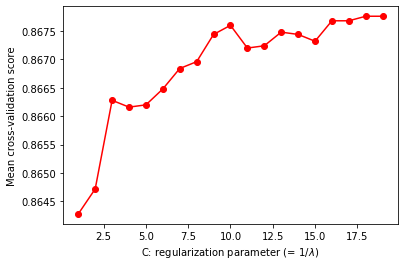

In [166]:
_  = plt.plot(C,cv_scores, 'ro-')
_=plt.xlabel('C: regularization parameter (= 1/$\lambda$)')
_= plt.ylabel('Mean cross-validation score')

In [173]:
clf_logreg_word2vec = LogisticRegression(C=10, random_state=42, max_iter=1000)
clf_logreg_word2vec.fit(train_wordvec_features, y_train)
logreg_pred_word2vec  = clf_logreg_word2vec.predict(test_wordvec_features)

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [174]:
show_metrics(y_test,logreg_pred_word2vec)
print(accuracy_score(y_test,logreg_pred_word2vec))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



,Predicted -ve,Predicted +ve
Actual -ve,10860,1640
Actual +ve,1634,10866


The AUC (under ROC curve) score is 0.86904
0.86904


**Mis-classification example: Logistic Regression**

In [158]:
ind_misclf = np.where(~(logreg_pred_word2vec == y_test))[0][0]
ind_misclf

2

In [159]:
print('Predicted: %i'%logreg_pred_word2vec[ind_misclf])
print('Actual: %i'%y_test[ind_misclf])

Predicted: 0
Actual: 1


In [160]:
print(test_df.iloc[ind_misclf]['reviews'])

To sum this story up in a few sentences: A teenage girl (Amy) uses her hot body and "supposed" virginity to entice a young troubled guy (Matt) with a potential football scholarship to provide her a "Full Ride" out of town. Come to find out she has quite the reputation & has slept with many football players in the past hoping they would offer her the same deal. Both of these kids have come from troubled & dysfunctional homes. Matt's mothers a alcoholic who repeatedly embarrasses him in front of his friends & Amy's mother had a bad reputation herself & got pregnant with Amy at a a young age. Matt falls in love with Amy & tries to straighten out his life for her. Very predictable ending. The actress that plays "Amy" is actually 33 years old trying to play a teenager!


### Random forest 

In [152]:
clf_rf_word2vec = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42,n_jobs=-1, min_samples_split=3) 
clf_rf_word2vec.fit(train_wordvec_features,y_train)
rf_pred_word2vec = clf_rf_word2vec.predict(test_wordvec_features)

show_metrics(y_test,rf_pred_word2vec)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



,Predicted -ve,Predicted +ve
Actual -ve,10314,2186
Actual +ve,2150,10350


The AUC (under ROC curve) score is 0.8265599999999999


In [175]:
clf_rf_word2vec = RandomForestClassifier(random_state=42,n_jobs=-1, min_samples_split=3) 
parameters = {'n_estimators': [200,500,700], 'max_depth': [10,15]}

rfmodel_word2vec = grid_search(clf_rf_word2vec, parameters, train_wordvec_features, y_train, n_folds=10)
rf_pred_word2vec = rfmodel_word2vec.predict(test_wordvec_features)

Best parameter values: {'max_depth': 15, 'n_estimators': 500} and best score = 0.83272


### Word2vec conclusion

We didn't get any performance improvement by using word embeddings in this particular problem. In fact, the accuracy scores dropped by a few per cent! 
- Why would that be?
Maybe the answer lies in the averaging process.




## Classification in a reduced featured space (LSA)

If you have ever heard about Pricnipal Componenet Analysis, that is conceptually the same thing as Latent Semantic Analysis, or, LSA. 

In [62]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)

train_svd = svd.fit_transform(train_features)
test_svd = svd.transform(test_features)
print(train_svd.shape)

(25000, 100)


In [74]:
print(train_features.shape)

(25000, 40000)


In [72]:
logreg_svd = LogisticRegression(solver = 'lbfgs',random_state=42)
parameters = {'C':np.arange(1,20,1)}
logreg_svd = grid_search(logreg_svd, parameters, train_svd, y_train, n_folds=10, score_func='accuracy')
logreg_pred_svd  = logreg_svd.predict(test_svd)

Best parameter values: {'C': 9} and best score = 0.86848


In [73]:
show_metrics(y_test,logreg_pred_svd)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



,Predicted -ve,Predicted +ve
Actual -ve,10799,1701
Actual +ve,1580,10920


The AUC (under ROC curve) score is 0.8687600000000001


- __*This is super cool! We have reduced the number of dimensions (features) from 40000 to 100, and still managed to achieve an accuracy that is just 2% less.*__

If I were low on resources and time, I would prefer reducing the dimensionality and then perform the classification, unless it is for a competition.